Today, we'll learn one of the most widely used state-of-the-art object detection algorithms -- YOLO. We'll apply this algorithm on both images and videos. 

Click on the image below to see some amazing results!

[<img src="https://pjreddie.com/media/image/yologo_2.png" width="400"/>](https://www.youtube.com/watch?v=MPU2HistivI)


Let's get started!

In [5]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }

import matplotlib.pyplot as plt
import os
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
import cv2
from copy import deepcopy

# Prepare data
DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)

image_url = 'https://drive.google.com/uc?id=12ZpZ5H0kJIkWk6y4ktGfqR5OTKofL7qw'
image_path = os.path.join(DATA_ROOT, 'image.jpg')
gdown.download(image_url, image_path, True)

image2_url = 'https://drive.google.com/uc?id=1_WpFbGEuS2r19UeP6wekbcF0kb-0nH18'
image2_path = os.path.join(DATA_ROOT, 'image2.jpg')
gdown.download(image2_url, image2_path, True)

video_url = 'https://drive.google.com/uc?id=1xFGjpzhZVYtNor9hJevvxysGESZJIMDz'
video_path = os.path.join(DATA_ROOT, 'video1.mp4')
gdown.download(video_url, video_path, True)

model_url = 'https://drive.google.com/uc?id=19XKJWMKDfDlag2MR8ofjwvxhtr9BxqqN'
model_path = os.path.join(DATA_ROOT, 'yolo_weights.h5')
gdown.download(model_url, model_path, True)

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]  

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def preprocess_input(image_pil, net_h, net_w):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image


def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = _sigmoid(netout[..., :2])
      netout[..., 4:]  = _sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w
          
          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]
              
              if((classes <= obj_thresh).all()): continue
              
              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height  
            
              box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_yolo_boxes(boxes_all, image_h, image_w, net_h, net_w)
    
    return boxes_all

def correct_yolo_boxes(boxes_, image_h, image_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
    return boxes
        
def do_nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(num_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1
        
        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                # print("{}: {}, ({}, {})".format(labels[i], box.classes[i]*100, box.xmin, box.ymin))
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)    

    return new_boxes


from PIL import ImageDraw, ImageFont
import colorsys

def draw_boxes(image_, boxes, labels):
    image = image_.copy()
    image_w, image_h = image.size
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
                    size=np.floor(3e-2 * image_h + 0.5).astype('int32'))
    thickness = (image_w + image_h) // 300

    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.

    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        predicted_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        #label_size = draw.textsize(label)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(image_w, np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        #draw.text(text_origin, label, fill=(0, 0, 0))
        del draw
    return image  

In [6]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Thu Dec 31 21:38:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W /  70W |    227MiB / 15079MiB |      2%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                            

# Milestone 1. What is YOLO?


The “You Only Look Once,” or YOLO, family of models are a series of end-to-end deep learning models designed for fast object detection, developed by Joseph Redmon, et al. and first proposed in the 2015 paper titled “[You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640).” The model has been updated since then. Today, we'll focus on YOLOv3, which is described in this very interesting [technical report](https://pjreddie.com/media/files/papers/YOLOv3.pdf). Today, we'll walk through the basic idea of the algorithm. If you'd like to know more details about it, definitely check out the papers! 

The approach involves a single deep convolutional neural network (DarkNet which is based on the VGG model we used before) that splits the input into a grid of cells and each cell directly predicts a bounding box and object classification. The result is a large number of candidate bounding boxes that are consolidated into a final prediction by a post-processing step.

For example, an image may be divided into a 7×7 grid and each cell in the grid may predict 2 bounding boxes, resulting in 98 proposed bounding box predictions. The class probabilities map and the bounding boxes with confidences are then combined into a final set of bounding boxes and class labels. The image taken from the paper below summarizes the two outputs of the model. 

In summary, to make object detection on one input image, the first step is a forward pass of the DarkNet; the second step is the post-processing on the DarkNet output to get the final bounding boxes prediction.

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/Summary-of-Predictions-made-by-YOLO-Model.png" width="600"/>











# Milestone 2. How does YOLO work?

Before we proceed to build the YOLO model, let's first define the **anchor boxes**, which are several pre-defined bounding boxes with useful shapes and sizes that are tailored based on the object shapes in the training dataset.

There are 9 anchor boxes in total. As we'll talk about later, the detection is performed on 3 scales. Therefore, the anchor boxes are divided into 3 groups, each corresponding to 1 scale.


In [7]:
anchors = [[[116,90], [156,198], [373,326]], [[30,61], [62,45], [59,119]], [[10,13], [16,30], [33,23]]]


The 9 anchor boxes are plotted below. As you may discover, they can cover a variety of shapes and sizes.

<img src="http://www.programmersought.com/images/401/891354390c3aab3f1ab1fd0db3110bf9.png" width="400"/>

Now, let's load the image that we'll apply object detection on. To load the image, we'll use the `Image` module in the package `PIL`, which is commonly used  for image processing. The image is saved as a `PIL image` in the variable `image_pil`. We can get the width and the height of the image by accessing the `size` attribute of the image. 


The type of the saved image is <class 'PIL.JpegImagePlugin.JpegImageFile'>


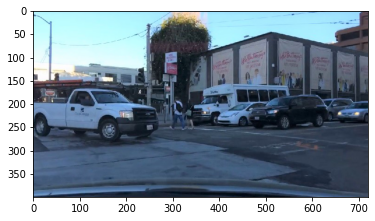

In [8]:
from PIL import Image
from matplotlib import  pyplot as plt

image_path = '/content/data/image.jpg'

image_pil = Image.open(image_path)
image_w, image_h = image_pil.size
print("The type of the saved image is {}".format(type(image_pil)))
plt.imshow(image_pil)
plt.show()

### Exercise (Coding) | Image Preprocessing

The input size of DarkNet is `(416, 416)`, so we need to preprocess our image into the required size by resizing our image, keeping the aspect ratio consistent, and padding the left out areas with the grey color, which is `(128,128,128)` in RGB. We have implemented the preprocessing for you in the `preprocess_input(image, net_h, net_w)` function, which takes the orininal image, the target height and width `net_h, net_w` as input and returns the new image in the required size. 

In the chunk below, do the preprocessing by yourself! Plot the new image to check your result


In [9]:
### YOUR CODE HERE

new_image = preprocess_input(image_pil, 416, 416)

### END CODE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


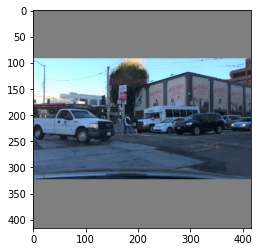

In [10]:
#@title Run this to check the new image { display-mode: "form" }
plt.imshow(new_image[0])
plt.show()

### Exercise (Discussion) | DarkNet Architecture

The main part of the YOLO algorithm is the DarkNet model, which is basiclly a Convolutional Neural Network, with some special designs, like upsampling layers and detection layers. 

Here is how the architecture of DarkNet looks like:


<img src="https://miro.medium.com/max/2000/1*d4Eg17IVJ0L41e7CTWLLSg.png" width="1000"/>

**The residual blocks** in the picture contain layers that are similar to the CNN models we built before, eg. convolutional layers `Conv2D`, max pooling layers `MaxPooling2D`, activation layers `Activation('relu')`. The network just stacks a lot more layers than the model we built before. 





**How to make detections at 3 different scales?**

Besides the stuff that we are familiar with, the most salient feature of YOLOv3 DarkNet is that it makes detections at three different scales, which are precisely given by downsampling the dimensions of the input image by 32, 16 and 8 respectively. 

The first detection is made by the 82nd layer. For the first 81 layers, the image is down sampled by the network, such that the 81st layer has a stride of 32. If we have an image of 416 x 416, the resultant feature map would be of size 13 x 13. 

The feature map size at layer 94 and 106 grows bigger because of the upsampling layers. The feature maps are upsampled by 2x to dimensions of 26 x 26 and 52 x 52 respectively.

**What exactly are the DarkNet outputs?**

The eventual detection output is generated by applying detection kernels on feature maps at the three different places in the network.

For each grid cell, we'll consider several possible bounding boxes that are centered at the given grid cell. Then for each considered bounding box, the model predicts t<sub>x</sub>, t<sub>y</sub>, t<sub>w</sub>, t<sub>h</sub>, an objectness score, and class scores.
- t<sub>x</sub>, t<sub>y</sub>, t<sub>w</sub>, t<sub>h</sub> are related to predicting the exact position and shape of the considered bounding box.
- The objectness score is the model's prediction about how likely the considered bounding box has a complete object inside it.
- Class scores are the predicted probability over all the object classes.

Therefore, the shape of the detection kernel is 1 x 1 x (B x (4 + 1 + C)). Here, 1 x 1 means the kernel only looks at one grid cell at one time. B is the number of bounding boxes a cell on the feature map can predict, "4" is for the 4 bounding box attributes (t<sub>x</sub>, t<sub>y</sub>, t<sub>w</sub>, t<sub>h</sub>) and "1" for the object confidence. C is the number of object classes. 

The model will consider bounding boxes based on the 3 anchor boxes defined before, so B = 3. As YOLO is trained on COCO (a large-scale object detection dataset), which contains 80 object catogories, C = 80. Therefore, the kernel size is 1 x 1 x 255. The feature map produced by this kernel has identical height and width of the previous feature map, and has detection attributes along the depth as described above.

The following picture illustrates how this works.

<img src="https://miro.medium.com/max/1200/0*3A8U0Hm5IKmRa6hu.png" width="500"/>



### Exercise (Coding and Discussion) | Forward Pass

Now, let's load a fully trained DarkNet model!

In [11]:
import tensorflow as tf

# Load model
darknet = tf.keras.models.load_model(model_path)

Just as how we got the classification predictions from the perceptron, CNN and VGG models, call the `model.predict(input_data)` function to do a forward pass on our preprocessed image `new_image`! 

After you get the output, check the structure of the output and discuss what the dimensions mean with you classmates!

In [12]:
### YOUR CODE HERE
yolo_outputs = darknet.predict(new_image)

### END CODE

In [13]:
print(len(yolo_outputs))
print(yolo_outputs[0].shape)
print(yolo_outputs[1].shape)
print(yolo_outputs[2].shape)

3
(1, 13, 13, 255)
(1, 26, 26, 255)
(1, 52, 52, 255)


In [14]:
yolo_outputs

[array([[[[ 3.8198376e-01, -7.8780174e-01, -2.9265258e-01, ...,
           -9.6703377e+00, -8.8358545e+00, -9.4411774e+00],
          [ 1.8961674e+00,  5.3337467e-01,  3.4583664e-01, ...,
           -9.0010643e+00, -9.3220482e+00, -1.0913366e+01],
          [-1.1359137e+00,  1.2001308e+00,  2.4857676e-01, ...,
           -8.4896507e+00, -7.8549218e+00, -8.1360226e+00],
          ...,
          [ 3.7715375e-01,  8.3284223e-01, -1.4388266e-01, ...,
           -8.3765774e+00, -9.2567492e+00, -1.0544571e+01],
          [-4.2474186e-01,  9.1069841e-01, -1.9159991e-01, ...,
           -6.6708479e+00, -8.3729105e+00, -8.0393496e+00],
          [-2.0817993e+00,  1.1254585e+00,  2.6701632e-01, ...,
           -5.0508332e+00, -6.6984148e+00, -5.9345345e+00]],
 
         [[ 9.4768763e-01,  3.0783013e-01, -3.4324446e-01, ...,
           -9.9244261e+00, -9.0633278e+00, -9.8426113e+00],
          [ 2.4070571e-01,  4.7848144e-01,  1.0634408e-01, ...,
           -1.0237247e+01, -9.7026777e+00, -1.1146

Answer the following questions:


*   How many elements are there in the `yolo_outputs`? Why?
*   What does each dimension of the `yolo_outputs[0]` mean?
*   Why the last dimension is 255?

If you are clear about the questions above, now you can definitely explain how the DarkNet works to your classmates! (At each detection scale, ... For each grid cell, ... For each bounding boxes, ...)

# Milestone 3. Bounding Box Prediction

We now have DarkNet's detection predictions for all the possible bounding boxes centered at each grid cell position, but to get the final detection results, which are the bounding boxes that the model is confident of, we need to apply a threshold to filter the results.

Besides, as you can imagine, there might be multiple bounding boxes that are detecting the same object. We need to remove the overlapping bounding boxes and only leave the best ones.

Here are some post-presessing steps:



*   `decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)` takes the DarkNet output feature maps `yolo_outputs` as input, and returns all the predicted bounding boxes that have a higher objectness than the objectness threshold `obj_thresh`
*   `do_nms(boxes, nms_thresh, obj_thresh)` means Non-Maximal Suppression, which a commonly used post-processing step for object detection. It  removes  all the bounding boxes that have a big (higher overlap than the `nms_thresh`) overlap with other better bounding boxes.
*   `draw_boxes(image_pil, boxes, labels)` draws the final bounding boxes on the input image and return the detection image as a `PIL image`.


### Exercise (Coding) | Post-processing for bounding box prediction

First, let's define the thresholds mentioned above:

In [15]:
obj_thresh = 0.1
nms_thresh = 0.3

Make use of the functions above to get our final detection bounding boxes and plot the result you get!


person 0.53 (325, 203) (348, 256)
car 0.96 (666, 191) (720, 241)
car 1.00 (653, 189) (720, 243)
car 0.85 (624, 190) (685, 239)
car 0.23 (621, 190) (677, 239)
car 0.12 (393, 200) (484, 247)
person 0.88 (325, 189) (348, 258)
person 0.10 (310, 189) (339, 253)
person 0.94 (297, 185) (328, 253)
car 0.26 (669, 190) (719, 233)
car 0.90 (650, 187) (720, 237)
car 0.28 (632, 186) (707, 231)
car 0.99 (625, 187) (688, 233)
car 0.67 (618, 189) (678, 233)
person 0.13 (101, 178) (125, 199)
person 0.17 (93, 178) (116, 199)
traffic light 0.12 (281, 155) (294, 175)
traffic light 0.45 (224, 123) (239, 153)
car 0.59 (632, 186) (720, 238)
car 0.45 (614, 185) (697, 234)
car 0.95 (478, 180) (635, 255)
car 0.98 (462, 180) (635, 257)
car 0.47 (375, 181) (534, 243)
car 0.29 (351, 184) (516, 243)
person 0.48 (296, 183) (342, 258)
bus 0.91 (353, 153) (554, 233)
bus 0.48 (339, 156) (537, 232)
truck 0.85 (0, 173) (274, 285)
bus 0.82 (345, 144) (571, 237)
bus 0.42 (326, 146) (547, 239)
truck 0.95 (0, 161) (268, 278)

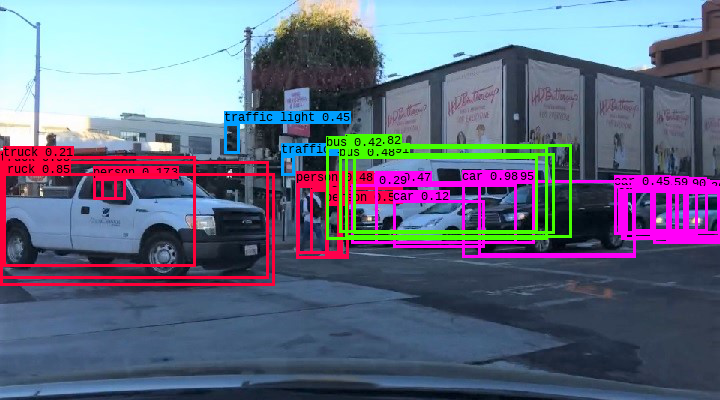

In [16]:
### Before NMS removes all the excess boxes
boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, 416, 416)
draw_boxes(image_pil, boxes, labels)


car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.94 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
person 0.17 (93, 178) (116, 199)
traffic light 0.12 (281, 155) (294, 175)
traffic light 0.45 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 257)
car 0.47 (375, 181) (534, 243)
bus 0.91 (353, 153) (554, 233)
car 0.23 (0, 173) (274, 285)
truck 0.32 (326, 146) (547, 239)
truck 0.95 (0, 161) (268, 278)


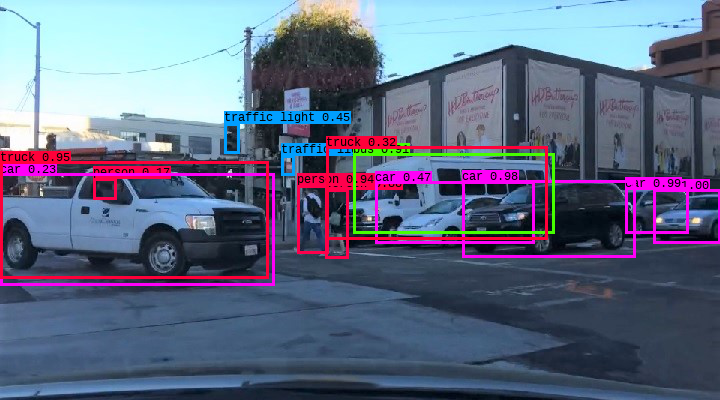

In [17]:
# After NMS removes all the overlapping boxes
boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, 416, 416)
boxes = do_nms(boxes, nms_thresh, obj_thresh)
draw_boxes(image_pil, boxes, labels)

### Exercise (Coding) | Non-Maximal Suppression

Good job! Are you curious about what each post-processing step is doing? You can explore this by yourself!

As a hint, you can...

*   Check the number of boxes after each step 
*   Call the `draw_boxes(image_pil, boxes, labels, obj_thresh)` function to visualize the bounding boxes after each step

In [18]:
### YOUR CODE HERE

### END CODE

### Exercise (Coding) | Image Detection Function

Our final goal is to detect objects in a video, which contains multiple frames (images). For better reusability and modularity, let's wrap all the code we wrote before in a function called `detect_image`, which takes the raw `PIL image` (without preprocessing) and other parameters as input, and returns the `PIl image` with detected bounding boxes and labels. Complete this function by yourself and test it

In [19]:
def detect_image(image_pil, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
  ### YOUR CODE HERE
  yolo_outputs = darknet.predict(preprocess_input(image_pil, net_h, net_w))
  w, h = image_pil.size
  boxes = decode_netout(yolo_outputs, obj_thresh, anchors, h, w, net_h, net_w)
  boxes = do_nms(boxes, nms_thresh, obj_thresh)
  return draw_boxes(image_pil, boxes, labels)
  ### END CODE

In [20]:
!wget -O img1.jpg "https://cdn.vox-cdn.com/thumbor/Q7_74k0zUmVCID7lnfaxKMuSaVU=/0x0:4000x2667/1200x800/filters:focal(1680x1014:2320x1654)/cdn.vox-cdn.com/uploads/chorus_image/image/65027193/shutterstock_788608396.0.jpg"

--2020-12-31 21:38:56--  https://cdn.vox-cdn.com/thumbor/Q7_74k0zUmVCID7lnfaxKMuSaVU=/0x0:4000x2667/1200x800/filters:focal(1680x1014:2320x1654)/cdn.vox-cdn.com/uploads/chorus_image/image/65027193/shutterstock_788608396.0.jpg
Resolving cdn.vox-cdn.com (cdn.vox-cdn.com)... 199.232.192.124, 199.232.196.124
Connecting to cdn.vox-cdn.com (cdn.vox-cdn.com)|199.232.192.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250630 (245K) [image/jpeg]
Saving to: ‘img1.jpg’

img1.jpg            100%[===================>] 244.76K  --.-KB/s    in 0.008s  

2020-12-31 21:38:56 (30.8 MB/s) - ‘img1.jpg’ saved [250630/250630]



In [21]:
image_pil = Image.open("/content/img1.jpg")
image_w, image_h = image_pil.size
print("The type of the saved image is {}".format(type(image_pil)))
plt.imshow(image_pil)
plt.show()
detect_image(image_pil)


Output hidden; open in https://colab.research.google.com to view.

In [36]:
!wget -O img2.jpg "https://i.insider.com/5e737fefc485404cff20d975"

--2020-12-31 21:42:41--  https://i.insider.com/5e737fefc485404cff20d975
Resolving i.insider.com (i.insider.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to i.insider.com (i.insider.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2971031 (2.8M) [image/jpeg]
Saving to: ‘img2.jpg’

img2.jpg            100%[===================>]   2.83M  --.-KB/s    in 0.04s   

2020-12-31 21:42:41 (68.2 MB/s) - ‘img2.jpg’ saved [2971031/2971031]



The type of the saved image is <class 'PIL.JpegImagePlugin.JpegImageFile'>


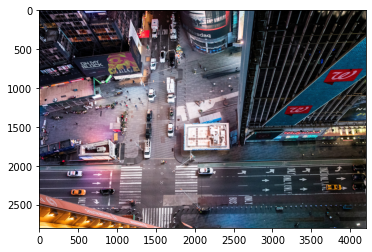

TypeError: ignored

In [37]:
image_pil = Image.open("/content/img2.jpg")
image_w, image_h = image_pil.size
print("The type of the saved image is {}".format(type(image_pil)))
plt.imshow(image_pil)
plt.show()
detect_image(image_pil)

In [ ]:
#@title Run this to check your function definition { display-mode: "form" }
plt.figure(figsize=(12,12))
plt.imshow(detect_image(image_pil))
plt.show()

### Exercise (Discussion) | Thresholds

Up till now, We used default values for the 2 thresholds, `objectness threshold` and `nms_threshold`. Do you understand what these 2 thresholds control? Make use of the `detect_image`function we defined above, try different values for the 2 thresholds in the range of 0-1 and see the changes in the results. Then discuss this with your classmates!

In [ ]:
### YOUR CODE HERE

### END CODE

# Milestone 4. Detection on Videos

A video is just a sequence of frames (images). Therefore, once we can use YOLO to detect objects on images, it's easy to extend this to videos. To deal with videos, we'll use the OpenCV package, which is called `cv2` in Python. If you are interested to know more, here is a [tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html).

The code below will open one video, create a new video file, read the input video frame-by-frame, and write each frame into the new video. 

Now modify the code by yourself to get the object detection result on the input video!

Remember that the image input for the `detect_image` function is a `PIL image`, but here we are loading the input video using `OpenCV`. These 2 image formats are different, so we need to convert `OpenCV` to `PIL` for detection, and convert back to write the frame into the new video.

The conversion can be done as follows
```
# OpenCV -> PIL
image_pil = Image.fromarray(cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB))

# PIL -> OpenCV
image_cv2 = cv2.cvtColor(np.asarray(image_pil), cv2.COLOR_RGB2BGR)
```

In [ ]:
import cv2

def detect_video(video_path, output_path, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'mp4v')
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    
    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

    num_frame = 0
    while vid.isOpened():
      ret, frame = vid.read()
      num_frame += 1
      print("=== Frame {} ===".format(num_frame))
      if ret:
          ### YOUR CODE HERE
          new_frame = frame
          # convert image type from opencv to PIL
          image_pil = Image.fromarray(cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB)) 
          processed_image = detect_image(image_pil)
          image_cv2 = cv2.cvtColor(np.asarray(processed_image), cv2.COLOR_RGB2BGR)
          ### END CODE          
          out.write(image_cv2)
      else:
          break
    vid.release()
    out.release()
    print("New video saved!")

Now test your code! You can check the output video in the FILES on the left

In [ ]:
video_path = '/content/data/video1.mp4'
output_path = '/content/data/video1_detected.mp4'
detect_video(video_path, output_path)